<center><h1>QBUS6850 - Machine Learning for Business</h1></center>

# Tutorial 12 - Matrix Factorisation

## NMF (or NNMF)

It is important to understand that NMF does not produce a unique solution or recover the original generative process exactly. This is because there exists a large number of basis vector and coefficent pairs that can reconstruct the data.

Below I illustrate a synthetic situation to illustrate this point.

However please keep in mind that you can influence the solution towards a unique solution. For example in spectral signal recovery we can apply temporal smoothness regularisation or sparsity on the coefficients. 

**Note**: in the lecture slides the data matrices $\mathbf X$ or $\mathbf V$ are assumed to have features as rows and observations as columns, as in Lee and Seung (1999), Gillis (2014). However in sklearn.decomposition. NMF the matrices are assumed to have observations as rows and features as columns. 

This actually does not matter and will not affect our interpretation. Python only knows the we have a input matrix and then does the NMF decomposition. We can define the meanings of rows and columns, and just use the output $\mathbf W$ and $\mathbf H$ from Python and use the interpretations in the lecture slides.

More specifically, our interpretation:

$\mathbf V$: shape (n_features, n_samples). Data matrix to be decomposed

$\mathbf W$: shape (n_features, n_components)

$\mathbf H$: shape (n_components, n_samples)

sklearn.decomposition.NMF:

$\mathbf X$: shape (n_samples, n_features). Data matrix to be decomposed

$\mathbf W$: shape (n_samples, n_components)

$\mathbf H$: shape (n_components, n_features)


In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF

# 100 (features) x 200 (examples) = 100 x 5 by 5 x 200
n_features= 100
n_examples = 200
r = 5

# Low-rank basis (orthogonal columns)
basis_w = np.dot(np.random.rand(n_features, r), np.random.rand(r, r))

# Random coefficients
coefs_h = np.random.rand(r, n_examples)
# Note here V has rows as features and columns as examples,
# This is consitent as Lecture notations, so we use the same W and H interpretations as in the lecture slides.
V = np.dot(basis_w, coefs_h)

model = NMF(n_components=r, init='random', random_state=0)

Calling fit_transform will calculate the NMF decomposition and return the basis $\mathbf W$.

In [2]:
W = model.fit_transform(V)

print(W.shape)

(100L, 5L)


To obtain the coefficients $\mathbf H$

In [3]:
H = model.components_

print(H.shape)

(5L, 200L)


Let's check how accurately we can reconstruct the original data.

Increasing number of components will increase accuracy of reconstruction.

In [4]:
reco = np.dot(W, H)

diff = V - reco

print(np.linalg.norm(diff) / np.linalg.norm(V))

0.0145070689741


Then we can compare the true basis matrix and estimated basis matrix. Note that they are very different!

In [5]:
pd.DataFrame(basis_w).head()

,0,1,2,3,4
0,1.995204,1.522131,0.994174,1.633033,1.182603
1,1.666269,1.214805,1.087798,1.287419,0.911327
2,1.094726,0.712140,0.841214,0.626191,0.398900
3,1.516873,1.236088,0.684810,1.313989,1.112113
4,2.052779,1.480544,1.153964,1.786859,0.880630


Estimated basis matrix

In [6]:
pd.DataFrame(W).head()

,0,1,2,3,4
0,2.280222,1.571746,0.830152,0.182706,0.877273
1,1.505232,0.991041,0.750181,0.695102,0.756007
2,0.543697,0.248191,0.453040,0.923328,0.501885
3,1.916538,1.365104,0.704914,0.000000,0.648246
4,1.886373,1.197557,0.706303,0.770894,1.068180


## Market Movement Analysis

One of the powerful applications of NNMF is clustering via the underlying generative process.

This is in contrast to traditional clustering methods such as k-means. These traditional clustering methods rely on vector distance metrics. This usually leads to clustering of stocks that are of a similar price.

However what we are usually more interested in is "which stocks move together?".

By performing NNMF we can produce a set of basis vectors and coefficients. The basis vectors can be roughly interpreted as unknown factors that affect the stock price. The coefficients of each stock are then treated as a similarity. In other words if stocks have similar coefficient patterns then they will likely move together.

So the process is to perform NNMF and then cluster stocks based on their coefficients.

In this example we look at the 30 component stocks of the Dow Jones Industrial Average over 25 weeks.

### Note V transpose has rows as dates (features) and columns as stocks (examples)
### Then V transpose is used for NMF algorithm

In [7]:
from sklearn.cluster import KMeans

np.random.seed(0)

dow_jones = pd.read_csv("dow_jones_index.data")

V = dow_jones.pivot(index = "stock", columns = "date", values = "close")

V = V.replace('[\$,]', '', regex=True).astype(float)
# V transpose has rows as dates (features) and columns as stocks (examples)
V= V.T
V.head()

stock,AA,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
1/14/2011,15.97,46.25,70.07,15.25,94.01,21.21,92.83,49.80,39.29,18.82,...,34.23,28.30,18.34,65.53,28.43,54.63,79.08,35.46,54.81,77.84
1/21/2011,15.79,46.00,71.68,14.25,92.75,20.72,93.78,48.35,39.74,19.74,...,33.90,28.02,18.36,65.91,28.33,55.00,80.20,34.95,55.73,78.98
1/28/2011,16.13,43.86,69.23,13.60,95.68,20.93,93.37,50.29,38.85,20.20,...,33.07,27.75,18.15,64.20,27.49,55.81,81.43,35.63,56.70,78.99
1/7/2011,16.42,44.36,69.38,14.25,93.73,20.97,91.19,49.76,39.45,18.43,...,37.35,28.60,18.34,64.50,28.85,53.33,79.08,35.93,54.08,75.59
2/11/2011,17.37,46.75,72.14,14.77,103.54,18.70,96.45,54.58,43.41,21.33,...,33.07,27.25,18.83,64.73,28.47,58.99,85.20,36.39,55.69,82.82


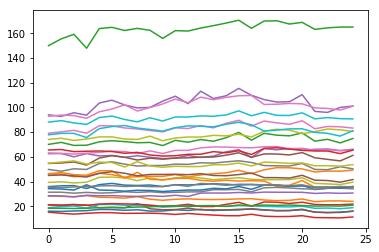

In [8]:
import matplotlib.pyplot as plt

# Plot individual stock prices
fig1 = plt.figure()

plt.plot(V.values)
fig1

In [9]:
model = NMF(n_components=5, init='random', random_state=0, max_iter=10000)

In [10]:
W = model.fit_transform(V)

print(W.shape)

(25L, 5L)


In [11]:
H = model.components_

print(H.shape)

(5L, 30L)


Group stocks by their cluster assignment for interpretation.Or cluster stocks based on their coefficients.

In [12]:
# kmeans treats row as training example, so transpose H
kmeans = KMeans(n_clusters=7, random_state=0).fit(H.T)
# generate clustering labels for each training example
labels = kmeans.labels_

groups = [list() for i in range(7)]

for i in range(len(labels)):
    g = labels[i]
    groups[g].append(V.columns[i])

for i in range(len(groups)):
    print("Stock group {0}: ".format(i) + str(groups[i]))

Stock group 0: ['AA', 'AXP', 'DD', 'DIS', 'GE', 'HD', 'INTC', 'KRFT', 'MRK', 'PFE', 'T', 'VZ', 'WMT']
Stock group 1: ['CAT']
Stock group 2: ['JNJ', 'KO', 'MCD', 'PG']
Stock group 3: ['IBM']
Stock group 4: ['BA', 'TRV', 'UTX']
Stock group 5: ['BAC', 'CSCO', 'HPQ', 'JPM', 'MSFT']
Stock group 6: ['CVX', 'MMM', 'XOM']


## Topic Modelling/Extraction

Given a collection of documents we can use NMF to automatically find words (features) which are most relevant to each topic (basis vector).

The number of topics is controlled by the number of basis vectors.

In this example we will use the twenty newsgroup dataset to find 10 topics and the most important words in those topics.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))

data_samples = dataset.data[:n_samples]

Build a tfidf representation that removes stop words and filters out words that occur in 95% of documents

### Still we transpose the data so that we have rows as features (1000) and columns as samples (2000)
### Then tfidf transpose is used for NMF algorithm

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Transpose the data so that we have rows as features (1000) and columns as samples (2000)
tfidf= tfidf.T
print(tfidf.shape)

(1000, 2000)


Each column of $\mathbf W$ represents one topic: 10 topics in total

In [15]:
nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=10000)
W = nmf.fit_transform(tfidf)
W.shape

(1000L, 10L)

Display the top 15 words in each topic (10 topics in total)

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(W.T):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

        
n_top_words = 15

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0: just don like think ve got sure really good ll know way use look want
Topic #1: edu soon com send university internet ftp mail mit information article pub cc address email
Topic #2: drive drives hard card disk software floppy pc mac apple computer power scsi controller memory
Topic #3: windows file dos using program use window files problem help os application running drivers version
Topic #4: thanks know does mail advance hi info interested anybody email looking help appreciated card information
Topic #5: people did time government law israel said say rights state right make let case evidence
Topic #6: game team year games win play season players nhl runs toronto flyers division goal hockey
Topic #7: key chip clipper keys encryption government use public phone secure enforcement nsa data doesn law
Topic #8: god jesus bible faith does christian christians christ believe life heaven sin lord church religion
Topic #9: car new 00 bike 10 price cars sale good power engine year sp

## Face Feature Extraction.

This example is from the lecture. We can extract image features for applications such as compression and feature engineering.

### Still transpose the data so that we have rows as features (1850) and columns as samples (1288)

In [17]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Images in the LFW dataset are 50*37 pixels in size.
# Therefore 1850 features in total.
# n_samples is the number of images

n_samples, a, b = lfw_people.images.shape
V = lfw_people.data
# Transpose the data so that we have rows as features (1850) and columns as samples (1288)
V= V.T

Display an example face (1st face of the input). Note here each column represents one face image.

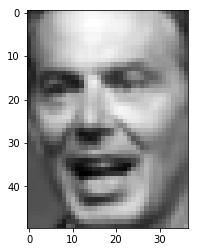

In [18]:
fig = plt.figure()
plt.imshow(V[:,1].reshape((a, b)), cmap=plt.cm.gray)
fig

Let's do a NNMF decomposition with 50 basis vectors

In [19]:
model = NMF(n_components=50, init='random', random_state=0)

W = model.fit_transform(V)

H = model.components_

Visualise the basis vectors

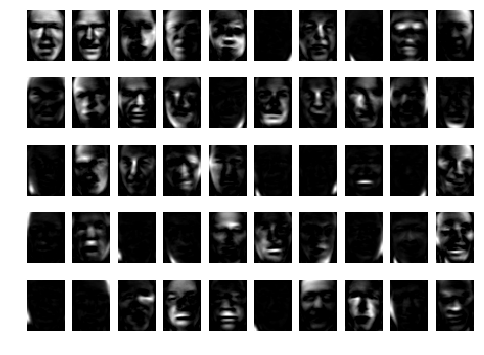

In [20]:
fig, axarr = plt.subplots(5, 10, figsize=(8, 6))

axarr_list = np.ravel(axarr)

for i in range(50):
    # each coolumn of W represent one basis vector
    axarr_list[i].imshow(W[:,i].reshape((a, b)), cmap=plt.cm.gray)
    axarr_list[i].axis('off')
fig   

Check the approximation $\mathbf W$$\mathbf H$  (1st face of the approximation)

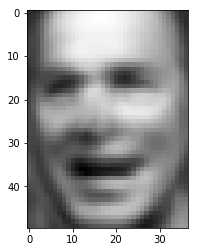

In [21]:
V_Approx= np.dot(W, H)

fig = plt.figure()
plt.imshow(V_Approx[:, 1].reshape((a, b)), cmap=plt.cm.gray)
fig

## Singular Value Decomposition

SVD is a central part of these algorithms and is often the bottleneck. Below we illustrate the various types of SVD and their pros/cons.

There are four options:
- Full SVD
- Partial SVD (optional)
- Sparse SVD (optional)
- Approximate SVD (optional)

In [22]:
import scipy.sparse.linalg as sparse
import scipy as sp
import numpy as np
import time

n = 1000
m = 900
r = 5
A = np.dot(np.random.randn(n, r), np.random.randn(r, m))

print(A.shape)
print(np.linalg.matrix_rank(A))

(1000L, 900L)
5


### Full SVD

Full SVD decomposition generates full size matrices for U, S and V.

Full SVD, has approximately $O(n^3)$ time complexity and does not scale well to large matrices or matrices with large rank.

In [23]:
tic = time.time()

U, s, V = sp.linalg.svd(A, full_matrices=True)

toc = time.time()

print("U: " + str(U.shape))
print("s: " + str(s.shape))
print("V: " + str(V.shape))


S = np.zeros((1000, 900))
S[:900, :900] = np.diag(s)
print("Running time: {0}s. Error: {1}".format(toc - tic, np.linalg.norm(U.dot(S).dot(V) - A)))

U: (1000L, 1000L)
s: (900L,)
V: (900L, 900L)
Running time: 0.213000059128s. Error: 3.40299407408e-12


Impact of full_matrices parameter. When full_matrices=False, this is also called reduced SVD. Note the difference for the sizes of matrix $\mathbf U$ between full_matrices=True and full_matrices=False.

In [24]:
tic = time.time()

U, S, V = sp.linalg.svd(A, full_matrices=False)

toc = time.time()

print("U: " + str(U.shape))
print("S: " + str(S.shape))
print("V: " + str(V.shape))

print("Running time: {0}s. Error: {1}".format(toc - tic, np.linalg.norm(U.dot(np.diag(S)).dot(V) - A)))

U: (1000L, 900L)
S: (900L,)
V: (900L, 900L)
Running time: 0.25s. Error: 3.40299407408e-12


### Partial and Sparse SVD

A partial SVD is performing an SVD on only the top $k$ singular values. Partial SVD is also known as truncated SVD or skinny SVD.

A sparse SVD is performing an SVD on a sparse matrix.

In scipy, the partial and sparse SVD function is shared. This function implements a different SVD solver that takes advantage of computing the SVD of a sparse input matrix OR computing a reduced number of singular values.

Notice that computing a partial SVD is significantly quicker and the error is still relatively small.

In [25]:
tic = time.time()
U, S, V = sparse.svds(A, k=r)
toc = time.time()

print("U: " + str(U.shape))
print("S: " + str(S.shape))
print("V: " + str(V.shape))

print("Running time: {0}s. Error: {1}".format(toc - tic, np.linalg.norm(U.dot(np.diag(S)).dot(V) - A)))

U: (1000L, 5L)
S: (5L,)
V: (5L, 900L)
Running time: 0.029000043869s. Error: 2.01073009901e-12


### Approximate SVD

Approximate SVD is a technique that uses randomisation to quickly compute an approximate SVD result.

More details are available here:
- https://arxiv.org/pdf/0909.4061.pdf
- https://amath.colorado.edu/faculty/martinss/Talks/2015_02_chicago.pdf

Suffice to say that the approximate SVD scales nicely to huge matrices and results in a suprisingly accurate result. For massive scale machine learning it is the only solution.

In [26]:
def random_svd(A, k):
    omega = np.random.randn( A.shape[1], r )
    Y = np.dot(A, omega)
    Q = sp.linalg.orth(Y)
    B = np.dot(np.transpose(Q), A)
    Uhat, S, V = sp.linalg.svd(B, full_matrices=False)
    U = np.dot(Q, Uhat)
    
    return U, S, V

tic = time.time()
[U, S, V] = random_svd(A, k=5)
toc = time.time()

print("U: " + str(U.shape))
print("S: " + str(S.shape))
print("V: " + str(V.shape))

print("Running time: {0}s. Error: {1}".format(toc - tic, np.linalg.norm(U.dot(np.diag(S)).dot(V) - A)))

U: (1000L, 5L)
S: (5L,)
V: (5L, 900L)
Running time: 0.0169999599457s. Error: 2.02448159717e-11
